# **Predicting A Heart Disease Diagnosis**

## **Introduction**

Heart disease, also known as cardiovascular disease, involves a range of conditions that affect the heart and blood vessels. It is a leading global health concern, responsible for a significant portion of mortality and morbidity and is the leading cause of death in the United States as of 2023. Various factors contribute to its development, including lifestyle choices, genetics, and environmental factors. Atherosclerosis, the buildup of plaque in arteries, commonly precedes the disease. Hypertension, high cholesterol, smoking, and obesity are key risk factors. Heart diseases manifest in diverse ways, such as angina, heart attacks, heart failure, and arrhythmias.

Studying risk factors for heart disease in middle to high-income countries, one would expect insights into various health factors that contribute to cardiovascular health in these populations. This analysis could uncover patterns related to lifestyle choices, such as smoking habits, the prevalence of atherosclerosis, rates of hypertension, and elevated cholesterol levels.

Understanding these factors can aid in tailoring targeted health interventions and policies to reduce the prevalence of heart disease. Additionally, the insights gained from the results and methodology of this study can contribute to developing accurate computer models for predicting heart disease. These models can enhance early risk assessment, personalized healthcare, and more effective disease management, ultimately leading to improved public health outcomes and reduced healthcare costs.

The aim of this project is to look at the predictive risk factors for heart disease and how significantly these factors contribute to the development of disease. Some of the specific variables that will be analyzed include resting heart rate, blood pressure and chest pain scores, ST-segment depression during exercise, cholesterol levels, maximum heart rate, whether exercise induces angina and more. Our question is whether a K-Nearest Neighbors algorithm can be used to predict whether a patient has heart disease and what the associated accuracy, precision and recall of the model are. The evaluated metrics of the model will determine whether the model is fit to be used in the real world to diagnose patients with heart disease based on their test results, which could save millions of dollars for taxpayers by reducing the stress that heart disease places on the medical system. For our analysis, we will use the Cleveland database that is stored in the Heart Disease data set in the UC Irvine Machine Learning Repository (refer to the "sources" section at the bottom for more information).

#### Before starting the data analysis, we will first:

1. Install all the necessary libraries.

2. Set the seed so that the results obtained are reproducible.

3. Set the default graph size.

In [1]:
#Installing Nececcary Libraries With Messages Suppressed
suppressPackageStartupMessages({
    library(tidyverse)
    library(repr)
    library(tidymodels)
})

options(repr.matrix.max.rows = 10)

#Set seed to make random results reproducible 
set.seed(13) 

#changing the default graph size:
options(repr.plot.width=10, repr.plot.height=8)

#### Now, we will import the Heart Disease data from the UC Irvine Repository:

In [2]:
#Importing data:

url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
temp <- tempfile()
download.file(url, temp)
data.hungary <- read.csv(unz(temp, "processed.hungarian.data"))
unlink(temp)

#### Next, we will format the data by:
1. Renaming columns to human-readable names.
2. Transforming each column to the proper data type (ex: character to integer or character to factor).


In [3]:
formatted_heart_disease<-data.hungary |> 
    #renaming columns 
    rename(age = X28, sex = X1, chest_pain_type = X2, resting_bp = X130, 
        cholesterol = X132, fasting_blood_sugar = X0, resting_ekg = X2.1, max_hr = X185, exercise_induced_angina = X0.1, 
        ST_drop_exercise = X0.2, ST_slope = X., fluoroscopy_count = X..1, thalassemia_type = X..2, vessel_narrow = X0.3
    )|>
    #transofrming variables from <char> to <int> or <fct>
    transform(resting_bp = as.integer(resting_bp), cholesterol = as.integer(cholesterol), 
        fasting_blood_sugar = as.integer(fasting_blood_sugar), resting_ekg = as.integer(resting_ekg), max_hr = as.integer(max_hr), 
        exercise_induced_angina = as.integer(exercise_induced_angina), ST_slope = as.integer(ST_slope),
        fluoroscopy_count = as.integer(fluoroscopy_count),thalassemia_type = as.integer(thalassemia_type), 
        vessel_narrow = as.factor(vessel_narrow), sex=as.integer(sex),chest_pain_type=as.integer(chest_pain_type))

formatted_heart_disease

Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ekg,max_hr,exercise_induced_angina,ST_drop_exercise,ST_slope,fluoroscopy_count,thalassemia_type,vessel_narrow
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
30,0,1,170,237,0,1,170,0,0,NA,NA,6,0
31,0,2,100,219,0,1,150,0,0,NA,NA,NA,0
32,0,2,105,198,0,0,165,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,1,4,160,331,0,0,94,1,2.5,NA,NA,NA,1
54,0,3,130,294,0,1,100,1,0.0,2,NA,NA,1
56,1,4,155,342,1,0,150,1,3.0,2,NA,NA,1


#### Before proceeding further into analyzing the data, we need to split it into a training and testing set: 
- The testing set will not be analyzed and will be set aside for testing later.
- %75 of the data will be used for testing and the remaining %25 for training.

In [4]:
heart_disease_split<-initial_split(formatted_heart_disease, prop=0.75, strata=vessel_narrow)
heart_disease_train<-training(heart_disease_split)
heart_disease_test<-testing(heart_disease_split)


#### Finally, to conclude the Data Wrangling, we will refactor the training data.
Using refactoring, we will convert numerical values to human readable (ex: 1/0 to male/female):

- `refactored_heart_train` will now be the human-readable training data frame for visualizations 
- `heart_disease_train` will remain not factored, because the K-Nearest Neighbors Algorithm requires numerical predictors

In [5]:
#According to the db: 
    #sex (1 = male; 0 = female)

    #chest pain type:
            # -- Value 1: typical angina
            # -- Value 2: atypical angina
            # -- Value 3: non-anginal pain
            # -- Value 4: asymptomatic

    #exercise induced angina (1 = yes; 0 = no)

    #esting electrocardiographic results
            # -- Value 0: normal
            # -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
            # -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

    #(fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

    #slope: the slope of the peak exercise ST segment
    #         -- Value 1: upsloping
    #         -- Value 2: flat
    #         -- Value 3: downsloping

    #thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

    #num: diagnosis of heart disease (angiographic disease status)
            # -- Value 0: < 50% diameter narrowing
            # -- Value 1: > 50% diameter narrowing
            # (in any major vessel: attributes 59 through 68 are vessels)

#Refactoring the above categorical variables to make the data more readable and easier to work with:
refactored_heart_train<-heart_disease_train|>
    transform(
        fasting_blood_sugar = as.factor(fasting_blood_sugar), resting_ekg = as.factor(resting_ekg), 
        exercise_induced_angina = as.factor(exercise_induced_angina), ST_slope = as.factor(ST_slope),
        thalassemia_type = as.factor(thalassemia_type), 
        vessel_narrow = as.factor(vessel_narrow), sex=as.factor(sex),chest_pain_type=as.factor(chest_pain_type
    ))|>
    mutate(sex=fct_recode(sex, "male"="1", "female"="0"
    ))|>
    mutate(chest_pain_type=fct_recode(chest_pain_type,
        "typical_angina"="1",
        "atypical_angina"="2",
        "non_anginal_pain"="3",
        "asymptomatic"="4"
    ))|>
    mutate(exercise_induced_angina=fct_recode(exercise_induced_angina,
        "yes"="1",
        "no"="0"
    ))|>
    mutate(resting_ekg=fct_recode(resting_ekg,
        "normal"="0",
        "ST-T_wave_abnormality"="1",
        "left_ventricular_hypertrophy"="2"
    ))|>
    mutate(fasting_blood_sugar=fct_recode(fasting_blood_sugar,
        "above120mg/dl"="1",
        "below120mg/dl"="0"
    ))|>
    mutate(ST_slope=fct_recode(ST_slope,
        "upsloping"="1",
        "flat"="2",
        "downsloping"="3"
    ))|>
    mutate(thalassemia_type=fct_recode(thalassemia_type,
        "normal"="3",
        "fixed_defect"="6",
        "reversable_defect"="7")
    )|>
    mutate(vessel_narrow=fct_recode(vessel_narrow,
        "below_50%of_d"="0",
        "above_50%of_d"="1"))
    
        
refactored_heart_train


,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ekg,max_hr,exercise_induced_angina,ST_drop_exercise,ST_slope,fluoroscopy_count,thalassemia_type,vessel_narrow
,<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
1,29,male,atypical_angina,120,243,below120mg/dl,normal,160,no,0,NA,NA,NA,below_50%of_d
2,29,male,atypical_angina,140,NA,below120mg/dl,normal,170,no,0,NA,NA,NA,below_50%of_d
3,30,female,typical_angina,170,237,below120mg/dl,ST-T_wave_abnormality,170,no,0,NA,NA,fixed_defect,below_50%of_d
5,32,female,atypical_angina,105,198,below120mg/dl,normal,165,no,0,NA,NA,NA,below_50%of_d
6,32,male,atypical_angina,110,225,below120mg/dl,normal,184,no,0,NA,NA,NA,below_50%of_d
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
286,50,male,asymptomatic,140,231,below120mg/dl,ST-T_wave_abnormality,140,yes,5.0,flat,NA,NA,above_50%of_d
287,50,male,asymptomatic,140,341,below120mg/dl,ST-T_wave_abnormality,125,yes,2.5,flat,NA,NA,above_50%of_d
289,52,male,asymptomatic,160,331,below120mg/dl,normal,94,yes,2.5,NA,NA,NA,above_50%of_d


## Exploratory Analysis
- With the data wrangling completed, we can proceed to perform exploratory analysis on the data set. 
- Exploratory analysis helps get a better understanding of the data before proceeding into any complex analysis and drawing any conclusions.

Below will will show how many data points we have for each age to get an idea of what population we are studying, and display it as a bar graph.

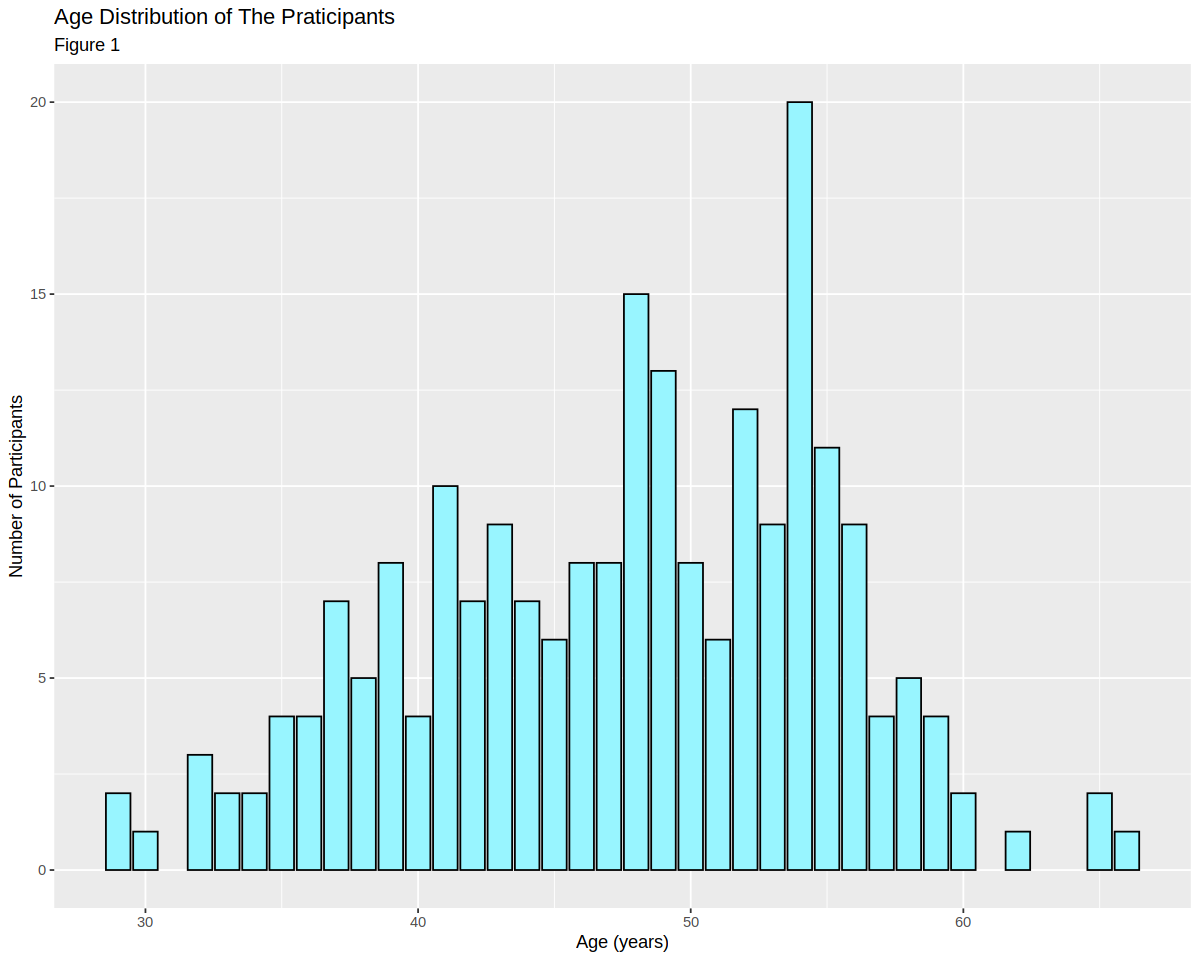

In [6]:
Summary_table <- refactored_heart_train |>
                count(age)

Summary_graph <-  ggplot(Summary_table, aes(x = age, y = n)) +
                    geom_bar(stat = "identity", fill="cadetblue1", color="black") +
                    labs(x = "Age (years)", y = "Number of Participants", subtitle="Figure 1")+
                    ggtitle("Age Distribution of The Praticipants")

Summary_graph

- From the graph above, we can see that the majority of participants are 30 to 60 years of age. 
- Since the age distribution is quite large, there could be a relationship between age and the narrow vessel diagnosis

The graph below will explore this relationship further:


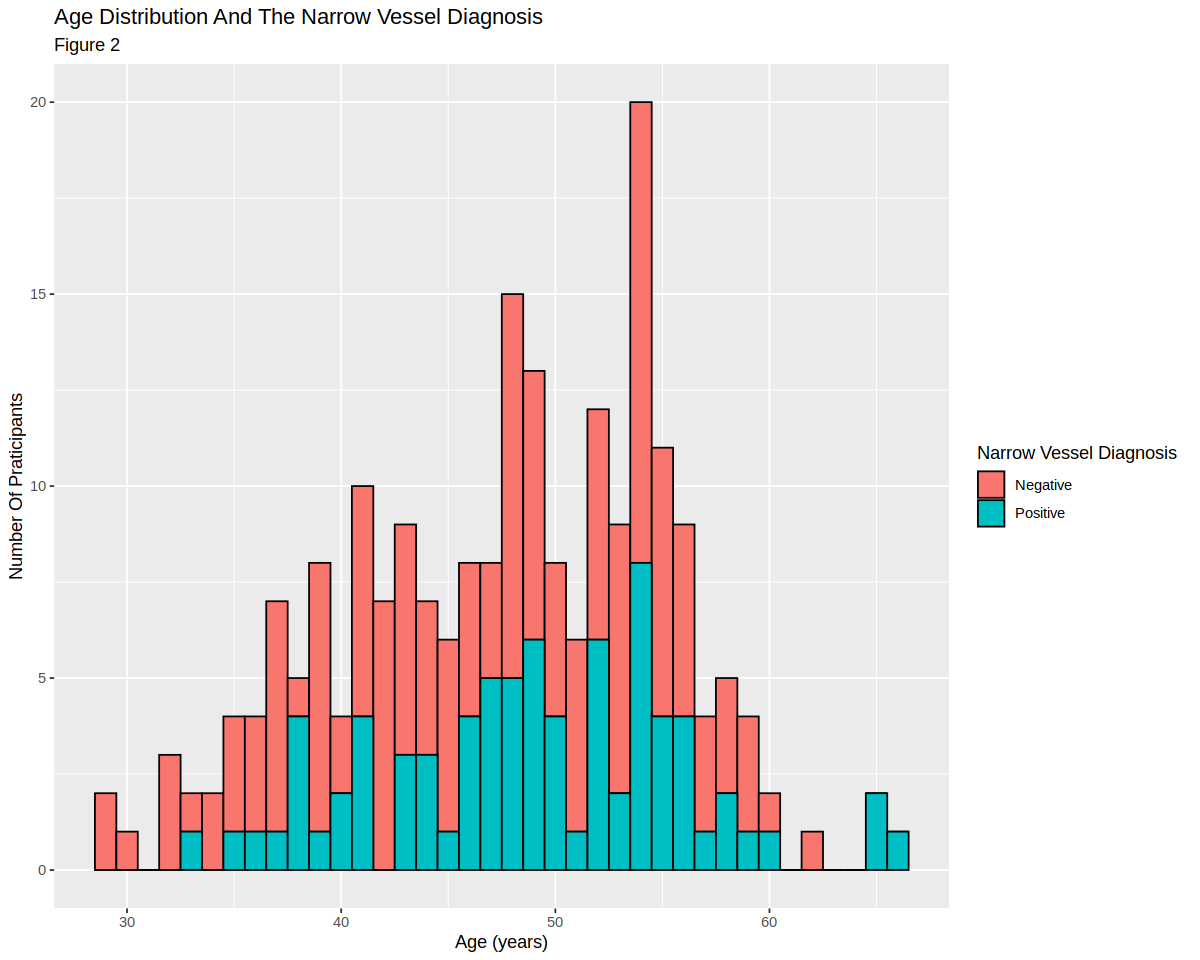

In [7]:
age_and_heart_desease_graph<-refactored_heart_train|>
    ggplot(aes(x=age, fill=vessel_narrow))+
        geom_histogram(binwidth=1, color="black")+
        labs(x="Age (years)",
             y="Number Of Praticipants",
             title="Age Distribution And The Narrow Vessel Diagnosis",
             subtitle="Figure 2"
            )+
        scale_fill_discrete(name="Narrow Vessel Diagnosis",
                    breaks = c("below_50%of_d", "above_50%of_d"),  # Current legend labels
                    labels = c("Negative", "Positive"))  # Human-redable labels

age_and_heart_desease_graph

The above visualization rejects the hypothesis that heart disease is strongly connected with age, as in this particular data set, the proportions of narrow vessel diagnosis for most ages are very similar.

Next, we will explore the relationship between chest pain type and the narrow vessel diagnosis:

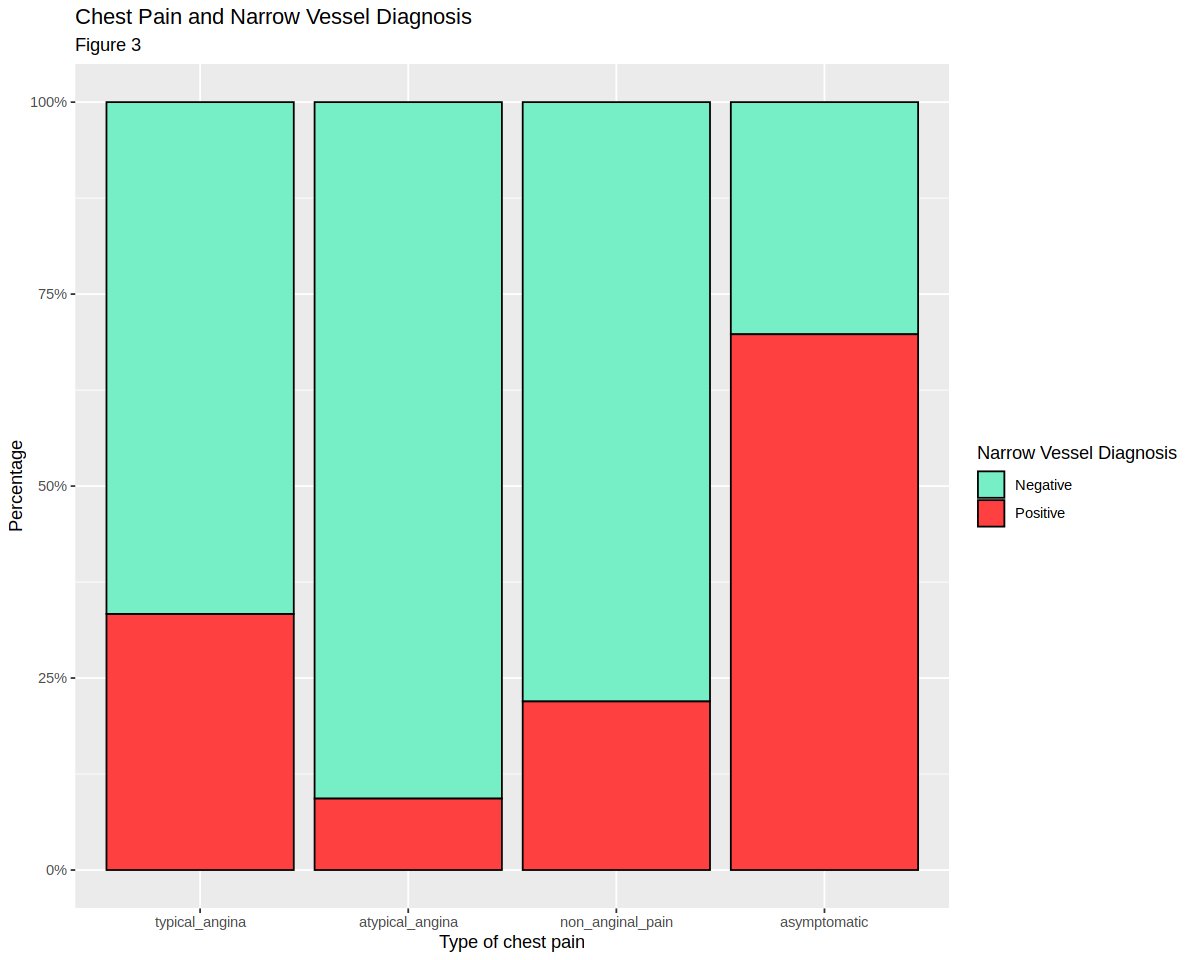

In [8]:
pain_vessel_graph<-refactored_heart_train|>
    ggplot(aes(x=chest_pain_type, fill=vessel_narrow))+
        geom_bar(position="fill", color="black")+
        scale_y_continuous(labels = percent_format(scale = 100)) +
        labs( title = "Chest Pain and Narrow Vessel Diagnosis",
             x="Type of chest pain",
             y="Percentage",
             subtitle="Figure 3"
            )+
        scale_fill_manual(
            name = "Narrow Vessel Diagnosis",
            breaks = c("below_50%of_d", "above_50%of_d"),
            labels = c("Negative", "Positive"),
            values = c("aquamarine2", "brown1")
          )
        

pain_vessel_graph

From the bar plot above, we can see that most heart disease diagnoses are associated with typical angina pain or asymptomatic pain. It is also clear that chest pain type can be useful for predicting a heart disease diagnosis. 

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


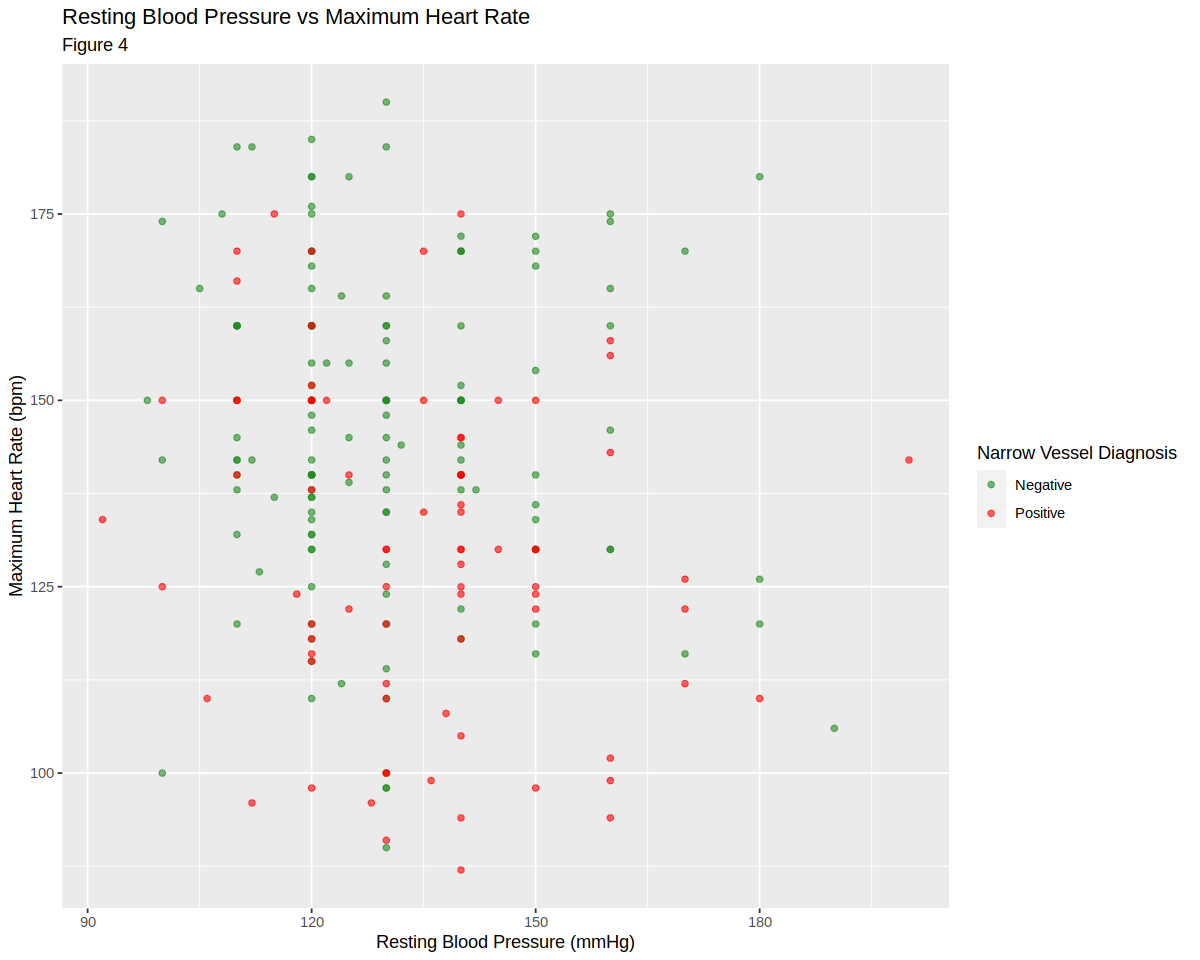

In [9]:
#Exploring the relationship between resting blood pressure, maximum heart rate and the narrow vessel diagnosis:
restingbp_maxhr_graph<-refactored_heart_train|>
    ggplot(aes(x=resting_bp, y=max_hr, color=vessel_narrow))+
        geom_point(alpha=0.6)+
        labs(title="Resting Blood Pressure vs Maximum Heart Rate",
             x="Resting Blood Pressure (mmHg)",
             y="Maximum Heart Rate (bpm)",
             color="Narrow Vessel Diagnosis",
             subtitle="Figure 4"
            )+
        scale_color_manual(
            name = "Narrow Vessel Diagnosis",
            breaks = c("below_50%of_d", "above_50%of_d"),
            labels = c("Negative", "Positive"),
            values = c("forestgreen", "red")
          )

restingbp_maxhr_graph

From the scatter plot above, we can see that the narrow vessel diagnosis is more likely to be negative at higher maximum heart rates. On the other hand, resting blood pressure does not have a strong visual relationship with the diagnosis. Therefore, it is likely that Maximum Heart Rate is a relevant predictor and resting blood pressure is an irrelevant predictor. 

## Forward Selection 

- Forward selection is a quick, algorithmic way of choosing the best combination of predictors for KNN
- It will save us time in visualizing every predictor and manually deciding which predictors are relevant and which aren't 

In [ ]:
#Using forward selection, determine what set of predictors will result in the highest accuracy 
#KNN classification 
#removing predictors with too many missing values 
heart_disease_train<-select(heart_disease_train, -ST_slope, -fluoroscopy_count,-thalassemia_type)
#removing rows with missing values
heart_disease_train <- na.omit(heart_disease_train)
#installing the kknn package
install.packages("kknn")

#extracting all the potential predictors from the data frame except for the categorical label variable vessel_narrow
names<-colnames(heart_disease_train |>select(-vessel_narrow))



#make an empty tibble for storing accuracies (used later)
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

#make your standard knn specification - every neighbour gets the same vote power, classification problem, kknn engine 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_disease_train, v = 2, strata = vessel_narrow)


number_of_predictors <- length(names)

# store the selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (index in 1:number_of_predictors) {
    # for every predictor:
    accuracy <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("vessel_narrow", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                            data = heart_disease_train) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the data frame
        accuracy[[j]] <- acc
        models[[j]] <- model_string
    }
    jbest <- which.max(unlist(accuracy))
    accuracies <- accuracies |> 
      add_row(size = index, 
              model_string = models[[jbest]], 
              accuracy = accuracy[[jbest]])
    selected <- c(selected, names[[jbest]])
    names <- names[-jbest]
}
accuracies



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




Since we are only interested in the most accurate combination of predictors, we can just use `slice_max()` to get the best combination of relevant predictors:

In [ ]:
most_accurate_predictors<-slice_max(accuracies, accuracy, n=1)
most_accurate_predictors

#### The forward selection resulted in the following combination of selectors:
- `exercise_induced_angina`
- `ST_drop_exercise`
- `cholesterol`
- `max_hr`

## Training The KNN Model

Now that we know what predictors result in the most accurate prediction model, we can train our K-Nearest Neighbors model to predict whether a patient has heart disease or not, based on the 4 selected predictors. To begin, we will select only the relevant values in the training data set and then remove all NAs.

In [ ]:
#select the predictors and response variable from the training set 
heart_disease_train<-heart_disease_train|>
    select(vessel_narrow,exercise_induced_angina,ST_drop_exercise,cholesterol,max_hr)

heart_disease_train <- heart_disease_train |> drop_na()




Next, we will use **Cross-Validation** to find the most optimal number of neighbours: the K value that results in the highest accuracy for our prediction model.
- Since the data frame is only 195 observations long, we will only test K values from 1 to 30.
    - Any value over 30 will likely cause overfitting for such a small data set.
- We will use 10-fold because it offers a good balance between speed and precision.

In [ ]:
k_values<-tibble(neighbors = seq(from = 1, to = 60, by = 1))

heart_vfold<-vfold_cv(heart_disease_train, v = 10, strata = vessel_narrow)


knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe<-recipe(vessel_narrow ~., data = heart_disease_train) |>
    step_scale(all_predictors( )) |>
    step_center(all_predictors( ))

knn_results<-workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = heart_vfold, grid = k_values) |>
      collect_metrics()

knn_results


Now, we will graph K vs accuracy to decide what K value to use (we could also do that by just using `slice_max`, but graphing the relation might grant us more insight and allow us to make a more informed decision at the expense of a few more lines of code).
- We will first filter out the columns where the `.metric` column value is equal to `accuracy`of our model
- Then we will first select the columns of interest for the graph
    - The `neighbors` that column contains the K-values 
    - The `mean` col that contains the estimated accuracy for each K-value 

- Finally, we will create a scatter plot with `neighbors` on the x-axis and `mean` on the y-axis

In [ ]:
knn_results<-knn_results|>
    filter(.metric=="accuracy")|>
    select(neighbors, mean)

In [ ]:


best_k_graph<-knn_results|>
    ggplot(aes(x=neighbors, y=mean))+
    geom_point()+
    geom_vline(aes(xintercept = neighbors), linetype = "solid", color = "lightblue", alpha = 0.5) +
    geom_line()+
    scale_x_continuous(limits = c(0, 60), breaks = seq(0, 60, by = 5))+
    labs(title="Value of K vs Prediction Accuracy",
         x="Number of Neighbors For K-NN",
         y="Prediction Accuracy",
         subtitle="Figure 5"
        )

best_k_graph

We should choose the value of K that is as high as possible but at the same time does not drop off when increased or decreased slightly. This approach will ensure that our model:
- Works well on new data, because even if the optimal K-value for the new data is slightly different, accuracy won't change significantly.
- Is as accurate as possible

By looking at the plot above we can see that the highest prediction accuracies occur at `K=7 and K=8`. We will use the value `K=7` because accuracy does not decrease as steeply to the left of point `K=7` compared to the right of point `K=8`. Therefore, judging by the graph, `K=7` will give us the highest accuracy and is more likely to fit new data points well.

**Now that we know what predictors and K value give us the highest prediction accuracy, we are going to train our final KNN model:**
- We will reuse the `knn_recipe` created earlier 
- `knn_best_spec` will now be set to `neighbors=7` instead of `neighbors=tune()`

In [ ]:
best_k=7

knn_best_spec<-nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit<-workflow()|>
    add_recipe(knn_recipe)|>
    add_model(knn_best_spec)|>
    fit(heart_disease_train)

**Finally, now that we have trained our final KNN Classification Model, we can test it using our testing data set, which was "put away" for future use at the beginning of our data analysis:**
- We will use our final model `knn_fit` to **predict** the heart disease diagnosis for every data point in our testing data set `heart_disease_test`
- Then, we will compare the **predicted values** with the **true values** and calculate the **accuracy** of our model

In [ ]:
heart_disease_test<-heart_disease_test|> 
    select(vessel_narrow, exercise_induced_angina, ST_drop_exercise, cholesterol, max_hr)
 
heart_disease_test<-heart_disease_test|>
    drop_na()

predictions_testing<-knn_fit|>
    predict(heart_disease_test)|>
    bind_cols(heart_disease_test)
    
predictions_testing

### Assessing The Prediction Model 

Now that we have made our final diagnosis predictions on the test data, it is time for the final phase of our analysis, which is model assessment.

- We will choose the positive and negative label 
    - The positive label will be vessel_narrow `above_50%of_d` as in the `refactored_heart_train` or `1` as in `heart_disease_test`
        >If we falsely diagnose heart disease, the patient will most likely get an appointment with a doctor later on and find out that they are in fact healthy. However, if we fail to identify heart disease a patient could potentially never get the treatment they require. Therefore, we will choose the **positive heart disease diagnosis** as the **positive label** for our calculations.
        
- Then, we will calculate the below metrics of our classifier: 
    - `accuracy`
    - `precision`
    - `recall` 
    
- After acquiring the above values, we will determine whether our predictive model could be of use in the real world and whether it could potentially benefit the medical field. 


In [ ]:
knn_accuracy<-predictions_testing |> 
    metrics(truth=vessel_narrow, estimate= .pred_class) |>
    filter(.metric=="accuracy")|>
    select(".estimate")|>
    pull()

confusion_matrix<-predictions_testing|>
    conf_mat(truth=vessel_narrow, estimate=.pred_class)

confusion_matrix

Using the **confusion matrix**, we can calculate the `precision` and `recall` of our predictive model:
- `Precision` is the number of **correct positive** predictions divided by the **total** number of **positive** predictions. 
    - Precision tells us how certain we are that a positive prediction is correct.
- `Recall` is the number of **correct positive** predictions divided by the **total** number of **positive observations** in the testing set.  
    - Recall tells us what percentage of positive labels have been correctly identified.
- Remember that in our case, `1` is the positive label and `0` is the negative label.
- `Accuracy` is already calculated above and it tells us what fraction of predictions is correct.
    -  Accuracy is the number of correct predictions divided by the number of total predictions made.

In [ ]:
#precision = true positive / (true positive + false positive)
precision=20/(20+8)

#recall = true positive / (true positive + false negative)
recall=20/(20+7)

cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")
cat("Accuracy:", knn_accuracy, "\n")

Now, let's convert all the metric estimates into percentages with two decimal points for better interpretability:

In [ ]:
precision_precentage <- sprintf("%.2f%%", precision * 100)
recall_precentage<- sprintf("%.2f%%", recall * 100)
knn_accuracy_precentage<- sprintf("%.2f%%", knn_accuracy * 100)

cat("Accuracy:", knn_accuracy_precentage, "\n")
cat("Precision:", precision_precentage, "\n")
cat("Recall:", recall_precentage, "\n")

Lastly, we will graph the predictions of our model to see where it excels and where it struggles. This could give us more insight into how it can be improved in further studies.

In [ ]:
prediction_graph<-predictions_testing|>
    mutate(correct_pred = ifelse(vessel_narrow == .pred_class, "correct", "incorrect"))|>
        ggplot(aes(x=max_hr, y=cholesterol, z=ST_drop_exercise, color=correct_pred))+
            geom_point(alpha=0.6)+
            labs(title="Cholesterol vs Maximum Heart Rate And Prediction Correctness",
                 subtitle="Figure 6",
                 x="Maximum Heart Rate (bpm)",
                 y="Cholesterol  (mg/dL)",
                 color="Prediction Correctness"
                 )+
            scale_color_manual(values = c("darkgreen", "red"))
                
prediction_graph

prediction_graph_2<-predictions_testing|>
    mutate(correct_pred = ifelse(vessel_narrow == .pred_class, "correct", "incorrect"))|>
        ggplot(aes(x=max_hr, y=ST_drop_exercise, color=correct_pred))+
            geom_point(alpha=0.6)+
            labs(title="ST-Segment Drop vs Maximum Heart Rate And Prediction Correctness",
                 subtitle="Figure 7",
                 x="Maximum Heart Rate (bpm)",
                 y="ST-Segment Drop (mm)",
                 color="Prediction Correctness"
                 )+
            scale_color_manual(values = c("darkgreen", "red"))

prediction_graph_2

The two graphs above show that the majority of incorrect guesses come from regions where there are not a lot of data points, which prevents the K-Nearest Neighbors Algorithm from making a correct prediction due to the limited amount of information. However, some incorrect predictions are overlaid directly on top of the correct ones. This could signal that there are other predictors important for the diagnosis that the database does not include, but we can not say that with certainty, as since in reality the model is calculating distance in 4D, a 2D graph is not a good representation of where data points are located and their relative distances from each other. Further research would be necessary to determine whether more predictors are necessary for the model or if it just requires more training data.

## **Discussion**

The above values show us that the model is accurate 77.61% of the time, it is precise 71.43%  of the time and the model has a recall value of 74.07%. In the case of identifying heart disease, `recall` is the most important metric because we need to be sure that we are identifying all heart disease cases. Our classifier is not exactly fit for the use case in the medical field, as an accuracy of 74.07% is inadequate considering how high the stakes of diagnosing heart disease are. 

These results are as expected as we did not have a large set of data to train the model with, which affected the quality of the model. However, despite the model trained in this study being not ready for use in the real world, it shows that it is possible to predict whether a patient has heart disease by looking at values of their ST-segment depression induced by exercise, cholesterol levels, maximum heart rate and whether exercise induces angina. This is promising because our training data set only had 195 rows. If we had access to data 10 or 100 times larger than that, say 2000 or 20,000 rows, the accuracy of our trained model could be much higher. This would make the process more computationally intensive, but could also result in a predictive model that is adequate for real-world use. 

This could mean that if more data is collected, future studies would be able to train more accurate models. Such research would lay the framework for future inquiries at the intersection of healthcare and data science. Moving forward this could include exploring optimization of interventions, long-term effects of risk factor modifications, and ethical considerations in predictive modelling, ultimately enhancing public health and data analytics.

## Sources

Below are some sources relevant to the project:
>UCI Machine Learning Repository. (n.d.). Archive.ics.uci.edu. https://archive.ics.uci.edu/dataset/45/heart+disease




 
>Centers for Disease Control and Prevention. (2022, September 8). Heart Disease and Stroke. Www.cdc.gov. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart

>Government of Canada. (2017, February 9). Heart Disease in Canada. Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

>American Heart Association News. (2019). Cardiovascular Diseases Affect Nearly Half of American Adults, Statistics Show. Www.heart.org. https://www.heart.org/en/news/2019/01/31/cardiovascular-diseases-affect-nearly-half-of-american-adults-statistics-show

‌
‌
‌
